# LGBM Regressor Baseline

*방향*

**농수축** 데이터에 대해 제공된 데이터에서 뽑아낼 수 있는 feature만 가지고 진행했을 때 어느 정도 맞는지 확인해 보자.

- train, test set split: cluster 기준 계층적 샘플링.
- 판매량을 넣었을 때, 안 넣었을 때 기준으로 MAPE 측정.

*문제*

- 군집을 반영해줄 수 없다!


*결과*

- 판매량 안 넣고 feature 사용할 때는 MAPE 스코어 0.37 정도.
- 판매량 안 넣었을 때는 판매단가가 제일 중요한 feature.
- 판매량 넣어서 feature 사용할 때는 MAPE 스코어 best 0.015 정도.
- 판매량 넣을 때는 판매량, 판매단가가 제일 중요한 feature.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
os.getcwd()
os.chdir("/content/drive/My Drive/Big-Contest")
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [3]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [4]:
# RAW_DATA = "./data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx"
RAW_DATA_EXPOSURE_FILLED = "./data/노출시간채운데이터.xlsx"
NSC_CLUSTERED_WITHOUT_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"
NSC_CLUSTERED_WITH_OUTLIERS = "./data/농수축_군집4개_이상치제외.csv"

In [5]:
data_raw = pd.read_excel(RAW_DATA_EXPOSURE_FILLED, usecols= lambda x: 'Unnamed' not in x)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    38309 non-null  datetime64[ns]
 1   노출(분)   38309 non-null  float64       
 2   마더코드    38309 non-null  int64         
 3   상품코드    38309 non-null  int64         
 4   상품명     38309 non-null  object        
 5   상품군     38309 non-null  object        
 6   판매단가    38309 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [6]:
data_nsc = data_raw[data_raw['상품군'] == '농수축']
print(data_nsc.info())
data_nsc['판매단가'].min(), data_nsc['판매단가'].max(), data_nsc['취급액'].min(), data_nsc['취급액'].max()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3884 entries, 29 to 38249
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    3884 non-null   datetime64[ns]
 1   노출(분)   3884 non-null   float64       
 2   마더코드    3884 non-null   int64         
 3   상품코드    3884 non-null   int64         
 4   상품명     3884 non-null   object        
 5   상품군     3884 non-null   object        
 6   판매단가    3884 non-null   int64         
 7   취급액     3884 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 273.1+ KB
None


(28900, 109900, 1292000.0, 270284000.0)

In [7]:
data = data_nsc.drop(columns=['상품군'], axis=1)
data = data.reset_index(drop=True)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0
...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0


## Feature 선택 1
- 월
- 일
- 요일
- 노출(분)
- 마더코드
- 상품코드
- 판매단가

In [8]:
# data['판매량'] = data['취급액'] / data['판매단가']
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액,월,일,요일
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0,1,1,화요일
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0,1,1,화요일
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0,1,1,화요일
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0,1,1,화요일
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0,1,1,화요일
...,...,...,...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0,12,31,화요일
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0,12,31,화요일
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0,12,31,화요일
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0,12,31,화요일


In [9]:
df = data[['월', '일', '요일', '노출(분)', '마더코드', '상품코드', '판매단가', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder

In [10]:
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,노출(분),마더코드,상품코드,판매단가,취급액
0,1,1,6,20.0,100496,201497,60900,14113000.0
1,1,1,6,20.0,100496,201497,60900,32395000.0
2,1,1,6,20.0,100496,201497,60900,39669000.0
3,1,1,6,20.0,100322,201479,49900,60787000.0
4,1,1,6,20.0,100322,201479,49900,115457000.0
...,...,...,...,...,...,...,...,...
3879,12,31,6,20.0,100253,200864,30900,54879000.0
3880,12,31,6,20.0,100253,200864,30900,63460000.0
3881,12,31,6,20.0,100812,202397,49900,34001000.0
3882,12,31,6,20.0,100812,202397,49900,54234000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       3884 non-null   int64  
 1   일       3884 non-null   int64  
 2   요일      3884 non-null   int64  
 3   노출(분)   3884 non-null   float64
 4   마더코드    3884 non-null   int64  
 5   상품코드    3884 non-null   int64  
 6   판매단가    3884 non-null   int64  
 7   취급액     3884 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 242.9 KB


In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

In [12]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

### 데이터셋 구성

In [14]:
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 파라미터 구성

#### 파라미터 조합 1

In [16]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

In [17]:
model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=1000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.456438
[200]	valid_0's mape: 0.413137
[300]	valid_0's mape: 0.394657
[400]	valid_0's mape: 0.387641
[500]	valid_0's mape: 0.382338
[600]	valid_0's mape: 0.38066
[700]	valid_0's mape: 0.379546
[800]	valid_0's mape: 0.379556
[900]	valid_0's mape: 0.380129
Early stopping, best iteration is:
[806]	valid_0's mape: 0.379256


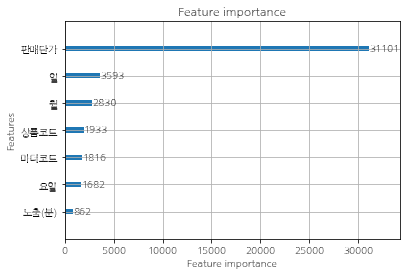

In [18]:
lgb.plot_importance(model)

In [19]:
y_pred = model.predict(X_test)
len(y_pred)

777

In [20]:
mean_absolute_percentage_error(y_test, y_pred)

37.925610390897354

In [21]:
test_data['취급액_예측'] = y_pred
test_data

,월,일,요일,노출(분),마더코드,상품코드,판매단가,취급액,취급액_예측
1960,8,6,6,20.00,100545,201630,38900,31298000.0,4.015728e+07
2704,9,19,1,18.25,100492,201487,49900,71481000.0,6.741155e+07
2127,8,18,4,20.00,100202,200685,55900,28919000.0,5.331014e+07
3471,11,22,0,20.00,100317,201665,49900,241079000.0,5.608210e+07
2366,8,30,0,20.00,100202,200685,55900,26805000.0,4.613590e+07
...,...,...,...,...,...,...,...,...,...
2362,8,29,1,20.00,100167,200579,38900,100719000.0,5.452965e+07
651,2,21,1,20.00,100849,202510,59900,61458000.0,4.055056e+07
1926,8,2,0,20.00,100199,200671,50900,20474000.0,3.717018e+07
3235,11,1,0,20.00,100323,201025,49900,62040000.0,5.141938e+07


#### 파라미터 조합 2


In [22]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.574207
[200]	valid_0's mape: 0.55514
[300]	valid_0's mape: 0.538087
[400]	valid_0's mape: 0.52263
[500]	valid_0's mape: 0.508525
[600]	valid_0's mape: 0.495918
[700]	valid_0's mape: 0.485502
[800]	valid_0's mape: 0.475237
[900]	valid_0's mape: 0.466718
[1000]	valid_0's mape: 0.459104
[1100]	valid_0's mape: 0.452144
[1200]	valid_0's mape: 0.445876
[1300]	valid_0's mape: 0.4401
[1400]	valid_0's mape: 0.435016
[1500]	valid_0's mape: 0.43018
[1600]	valid_0's mape: 0.426026
[1700]	valid_0's mape: 0.422336
[1800]	valid_0's mape: 0.418729
[1900]	valid_0's mape: 0.415593
[2000]	valid_0's mape: 0.412583
[2100]	valid_0's mape: 0.409572
[2200]	valid_0's mape: 0.40725
[2300]	valid_0's mape: 0.40489
[2400]	valid_0's mape: 0.402705
[2500]	valid_0's mape: 0.400716
[2600]	valid_0's mape: 0.398683
[2700]	valid_0's mape: 0.396889
[2800]	valid_0's mape: 0.395492
[2900]	valid_0's mape: 0.394293
[3000]	valid_0's mape: 0.

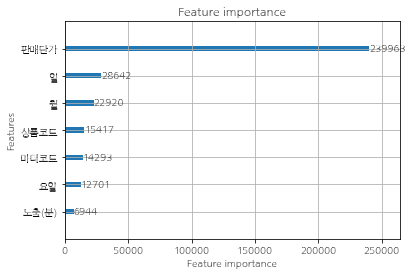

In [23]:
lgb.plot_importance(model)

In [24]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

37.69911290910791

In [25]:
test_data['취급액_예측'] = y_pred
test_data

,월,일,요일,노출(분),마더코드,상품코드,판매단가,취급액,취급액_예측
1960,8,6,6,20.00,100545,201630,38900,31298000.0,3.971548e+07
2704,9,19,1,18.25,100492,201487,49900,71481000.0,6.552552e+07
2127,8,18,4,20.00,100202,200685,55900,28919000.0,5.214668e+07
3471,11,22,0,20.00,100317,201665,49900,241079000.0,5.469496e+07
2366,8,30,0,20.00,100202,200685,55900,26805000.0,4.519784e+07
...,...,...,...,...,...,...,...,...,...
2362,8,29,1,20.00,100167,200579,38900,100719000.0,5.481491e+07
651,2,21,1,20.00,100849,202510,59900,61458000.0,4.106051e+07
1926,8,2,0,20.00,100199,200671,50900,20474000.0,3.821987e+07
3235,11,1,0,20.00,100323,201025,49900,62040000.0,5.457311e+07


#### 파라미터 조합 3

In [28]:
params = {'learning_rate': 0.0025, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':10}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.542898
[200]	valid_0's mape: 0.50411
[300]	valid_0's mape: 0.474897
[400]	valid_0's mape: 0.453076
[500]	valid_0's mape: 0.437871
[600]	valid_0's mape: 0.425947
[700]	valid_0's mape: 0.416797
[800]	valid_0's mape: 0.408363
[900]	valid_0's mape: 0.402667
[1000]	valid_0's mape: 0.398441
[1100]	valid_0's mape: 0.394006
[1200]	valid_0's mape: 0.39091
[1300]	valid_0's mape: 0.388051
[1400]	valid_0's mape: 0.386012
[1500]	valid_0's mape: 0.384428
[1600]	valid_0's mape: 0.383028
[1700]	valid_0's mape: 0.381455
[1800]	valid_0's mape: 0.379883
[1900]	valid_0's mape: 0.379077
[2000]	valid_0's mape: 0.378373
[2100]	valid_0's mape: 0.377959
[2200]	valid_0's mape: 0.377874
Early stopping, best iteration is:
[2135]	valid_0's mape: 0.377591


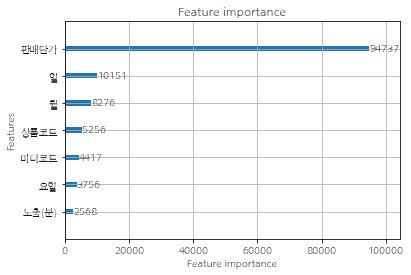

In [32]:
lgb.plot_importance(model)

## Feature 선택 2
- 월
- 일
- 요일
- 노출(분)
- 마더코드
- 상품코드
- 판매단가
- 판매량

In [8]:
data['판매량'] = data['취급액'] / data['판매단가']
data['월'] = data['방송일시'].dt.month
data['일'] = data['방송일시'].dt.day
data['요일'] = data['방송일시'].dt.dayofweek
day_mapping_dict = {0:'월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일', 6:'일요일'}
data['요일'] = data['요일'].map(day_mapping_dict)
data

,방송일시,노출(분),마더코드,상품코드,상품명,판매단가,취급액,판매량,월,일,요일
0,2019-01-01 15:00:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,14113000.0,231.740558,1,1,화요일
1,2019-01-01 15:20:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,32395000.0,531.937603,1,1,화요일
2,2019-01-01 15:40:00,20.0,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,60900,39669000.0,651.379310,1,1,화요일
3,2019-01-01 16:00:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,60787000.0,1218.176353,1,1,화요일
4,2019-01-01 16:20:00,20.0,100322,201479,국내산 손질갑오징어 8팩,49900,115457000.0,2313.767535,1,1,화요일
...,...,...,...,...,...,...,...,...,...,...,...
3879,2019-12-31 11:40:00,20.0,100253,200864,안동간고등어 20팩,30900,54879000.0,1776.019417,12,31,화요일
3880,2019-12-31 12:00:00,20.0,100253,200864,안동간고등어 20팩,30900,63460000.0,2053.721683,12,31,화요일
3881,2019-12-31 15:20:00,20.0,100812,202397,제주갈치+참조기세트,49900,34001000.0,681.382766,12,31,화요일
3882,2019-12-31 15:40:00,20.0,100812,202397,제주갈치+참조기세트,49900,54234000.0,1086.853707,12,31,화요일


In [9]:
df = data[['월', '일', '요일', '노출(분)', '마더코드', '상품코드', '판매단가', '판매량', '취급액']]
dtypes = df.dtypes

encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder

In [10]:
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

display(df)
df.info() 

,월,일,요일,노출(분),마더코드,상품코드,판매단가,판매량,취급액
0,1,1,6,20.0,100496,201497,60900,231.740558,14113000.0
1,1,1,6,20.0,100496,201497,60900,531.937603,32395000.0
2,1,1,6,20.0,100496,201497,60900,651.379310,39669000.0
3,1,1,6,20.0,100322,201479,49900,1218.176353,60787000.0
4,1,1,6,20.0,100322,201479,49900,2313.767535,115457000.0
...,...,...,...,...,...,...,...,...,...
3879,12,31,6,20.0,100253,200864,30900,1776.019417,54879000.0
3880,12,31,6,20.0,100253,200864,30900,2053.721683,63460000.0
3881,12,31,6,20.0,100812,202397,49900,681.382766,34001000.0
3882,12,31,6,20.0,100812,202397,49900,1086.853707,54234000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884 entries, 0 to 3883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   월       3884 non-null   int64  
 1   일       3884 non-null   int64  
 2   요일      3884 non-null   int64  
 3   노출(분)   3884 non-null   float64
 4   마더코드    3884 non-null   int64  
 5   상품코드    3884 non-null   int64  
 6   판매단가    3884 non-null   int64  
 7   판매량     3884 non-null   float64
 8   취급액     3884 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 273.2 KB


In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['요일']):
    train_data = df.loc[train_index]
    test_data = df.loc[test_index]

### 데이터셋 구성

In [12]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [13]:
ds_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)
ds_test = lgb.Dataset(X_test, label=y_test, categorical_feature=[0, 1, 2, 4, 5], free_raw_data=False)

### 파라미터 구성

#### 파라미터 조합 1

In [14]:
params = {'learning_rate': 0.001, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.540485
[200]	valid_0's mape: 0.489601
[300]	valid_0's mape: 0.443498
[400]	valid_0's mape: 0.401839
[500]	valid_0's mape: 0.364138
[600]	valid_0's mape: 0.329868
[700]	valid_0's mape: 0.298859
[800]	valid_0's mape: 0.270775
[900]	valid_0's mape: 0.245685
[1000]	valid_0's mape: 0.223092
[1100]	valid_0's mape: 0.202734
[1200]	valid_0's mape: 0.184298
[1300]	valid_0's mape: 0.167608
[1400]	valid_0's mape: 0.152541
[1500]	valid_0's mape: 0.138966
[1600]	valid_0's mape: 0.126715
[1700]	valid_0's mape: 0.115653
[1800]	valid_0's mape: 0.10559
[1900]	valid_0's mape: 0.0965595
[2000]	valid_0's mape: 0.0884225
[2100]	valid_0's mape: 0.081108
[2200]	valid_0's mape: 0.0744205
[2300]	valid_0's mape: 0.0683467
[2400]	valid_0's mape: 0.0628225
[2500]	valid_0's mape: 0.0577943
[2600]	valid_0's mape: 0.0532521
[2700]	valid_0's mape: 0.0490802
[2800]	valid_0's mape: 0.0453943
[2900]	valid_0's mape: 0.0420933
[3000]	va

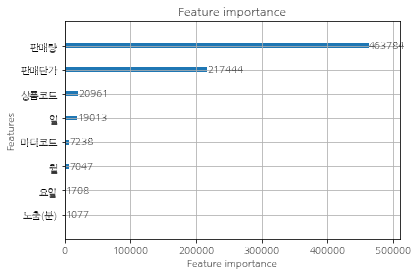

In [15]:
lgb.plot_importance(model)

In [16]:
y_pred = model.predict(X_test)
test_data['취급액_예측'] = y_pred
test_data

,월,일,요일,노출(분),마더코드,상품코드,판매단가,판매량,취급액,취급액_예측
1960,8,6,6,20.00,100545,201630,38900,804.575835,31298000.0,3.134383e+07
2704,9,19,1,18.25,100492,201487,49900,1432.484970,71481000.0,7.208205e+07
2127,8,18,4,20.00,100202,200685,55900,517.334526,28919000.0,2.890013e+07
3471,11,22,0,20.00,100317,201665,49900,4831.242485,241079000.0,1.335572e+08
2366,8,30,0,20.00,100202,200685,55900,479.516995,26805000.0,2.686495e+07
...,...,...,...,...,...,...,...,...,...,...
2362,8,29,1,20.00,100167,200579,38900,2589.177378,100719000.0,9.891756e+07
651,2,21,1,20.00,100849,202510,59900,1026.010017,61458000.0,6.288339e+07
1926,8,2,0,20.00,100199,200671,50900,402.239686,20474000.0,2.128468e+07
3235,11,1,0,20.00,100323,201025,49900,1243.286573,62040000.0,6.203216e+07


#### 파라미터 조합 2

In [17]:
params = {'learning_rate': 0.001, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':5}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.540485
[200]	valid_0's mape: 0.489601
[300]	valid_0's mape: 0.443498
[400]	valid_0's mape: 0.401839
[500]	valid_0's mape: 0.364138
[600]	valid_0's mape: 0.329868
[700]	valid_0's mape: 0.298859
[800]	valid_0's mape: 0.270775
[900]	valid_0's mape: 0.245685
[1000]	valid_0's mape: 0.223092
[1100]	valid_0's mape: 0.202734
[1200]	valid_0's mape: 0.184298
[1300]	valid_0's mape: 0.167608
[1400]	valid_0's mape: 0.152541
[1500]	valid_0's mape: 0.138966
[1600]	valid_0's mape: 0.126715
[1700]	valid_0's mape: 0.115653
[1800]	valid_0's mape: 0.10559
[1900]	valid_0's mape: 0.0965595
[2000]	valid_0's mape: 0.0884225
[2100]	valid_0's mape: 0.081108
[2200]	valid_0's mape: 0.0744205
[2300]	valid_0's mape: 0.0683467
[2400]	valid_0's mape: 0.0628225
[2500]	valid_0's mape: 0.0577943
[2600]	valid_0's mape: 0.0532521
[2700]	valid_0's mape: 0.0490802
[2800]	valid_0's mape: 0.0453943
[2900]	valid_0's mape: 0.0420933
[3000]	va

In [18]:
params = {'learning_rate': 0.025, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mape', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 1, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':42,
          'cat_smooth':15}

model = lgb.train(params=params, 
                  train_set=ds_train,
                  num_boost_round=10000,
                  valid_sets=ds_test, 
                  verbose_eval=100, 
                  early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's mape: 0.0572309
[200]	valid_0's mape: 0.0185637
[300]	valid_0's mape: 0.017274
[400]	valid_0's mape: 0.016953
[500]	valid_0's mape: 0.0169834
[600]	valid_0's mape: 0.016216
[700]	valid_0's mape: 0.0159721
[800]	valid_0's mape: 0.01572
[900]	valid_0's mape: 0.0154263
[1000]	valid_0's mape: 0.0154232
Early stopping, best iteration is:
[920]	valid_0's mape: 0.0152086
